In [1]:

import pandas as pd
import os
import shapely.geometry as sg
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint
from shapely.ops import unary_union
data_directory = os.path.join('..', 'datasets', 'ptv', '20240224')

In [2]:

ROUTE_TYPES = {
    0 : 'Tram',
    1 : 'Metro',
    2 : 'Rail',
    3 : 'Bus',
    4 : 'Ferry',
    5 : 'Cable tram',
    6 : 'Gondola',
    7 : 'Funicular',
    11 : 'Trolleybus',
    12 : 'Monorail',
}
ROUTE_TYPES_LONG = {
    0 : 'Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.',
    1 : 'Subway, Metro. Any underground rail system within a metropolitan area.',
    2 : 'Rail. Used for intercity or long-distance travel.',
    3 : 'Bus. Used for short- and long-distance bus routes.',
    4 : 'Ferry. Used for short- and long-distance boat service.',
    5 : 'Cable tram. Used for street-level rail cars where the cable runs beneath the vehicle, e.g., cable car in San Francisco.',
    6 : 'Aerial lift, suspended cable car (e.g., gondola lift, aerial tramway). Cable transport where cabins, cars, gondolas or open chairs are suspended by means of one or more cables.',
    7 : 'Funicular. Any rail system designed for steep inclines.',
    11 : 'Trolleybus. Electric buses that draw power from overhead wires using poles.',
    12 : 'Monorail. Railway in which the track consists of a single rail or a beam.',
}

BRANCH_IDS_ALL = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11']
BRANCH_IDS = ['1', '2', '3', '4', '5', '6', '10', '11']
TABLE_NAMES = ['stop_times', 'stops', 'trips', 'routes', 'calendar', 'calendar_dates', 'agency', 'shapes']
# GTFS File Fields
# agency.txt 
# agency_id, agency_name, agency_url, agency_timezone, agency_lang
# calendar.txt 
# service_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday, start_date, end_date
# calendar_dates.txt 
# service_id ,date, exception_type
# routes.txt 
# route_id, agency_id, route_short_name, route_long_name,
# route_type, route_color,route_text_color
# trips.txt 
# route_id, service_id, trip_id, shape_id, trip_headsign, direction_id
# stops.txt 
# stop_id, stop_name, stop_lat, stop_lon
# stop_times.txt 
# trip_id, arrival_time, departure_time, stop_id, stop_sequence, stop_headsign, pickup_type, drop_off_type, shape_dist_traveled
# shapes.txt 
# shape_id, shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled 
def get_df(branch_id, table_name):
    files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.split('-')[1] == str(branch_id) and f.split('-')[2] == table_name]
    if len(files) == 0:
        return None
    return pd.concat([pd.read_csv(f, keep_default_na=False, na_values=['']) for f in files])

DF = {branch_id: {table_name: get_df(branch_id, table_name) for table_name in TABLE_NAMES} for branch_id in BRANCH_IDS_ALL}
# 15s - 30s


In [3]:
DF['2']['routes']['route_id']

0      2-ain-mjp-1
1      2-ain-mjp-2
2      2-ain-mjp-4
3      2-ain-mjp-5
4      2-ALM-mjp-2
          ...     
110    2-WMN-mjp-5
111    2-WMN-mjp-6
112    2-WMN-mjp-7
113    2-WMN-mjp-8
114    2-WMN-mjp-9
Name: route_id, Length: 115, dtype: object

In [4]:
for bid in BRANCH_IDS_ALL:
    sf_routeidx = DF[bid]['routes']['route_id'].apply(lambda x: x.split('-'))
    DF[bid]['routes']['branch'] = sf_routeidx.apply(lambda x: x[0])
    DF[bid]['routes']['route_name'] = sf_routeidx.apply(lambda x: ''.join(x[1:-2]))
    DF[bid]['routes']['range'] = sf_routeidx.apply(lambda x: x[-2])
    DF[bid]['routes']['route_order'] = sf_routeidx.apply(lambda x: x[-1])
    DF[bid]['routes']['opbranch'] = bid


In [5]:
DFROUTES : pd.DataFrame = pd.concat([DF[bid]['routes'] for bid in BRANCH_IDS_ALL])

In [145]:
# DF_ROUTESINFO = DFROUTES.sort_values(['branch', 'route_name', 'range', 'route_order'])
# DFROUTES sort values by length of route_long_name
DFROUTES = DFROUTES.sort_values('route_long_name', key=lambda x: x.str.len(), ascending=False).sort_values(['opbranch', 'route_name'])
DF_ROUTESINFO = DFROUTES.drop_duplicates(subset=['opbranch', 'route_name'], keep='first')
DF_ROUTESINFO = DF_ROUTESINFO[['opbranch', 'route_name', 'route_short_name', 'route_long_name', 'route_type', 'route_color', 'route_text_color']]
DF_ROUTESINFO.rename(columns={'route_name': 'route_code'}, inplace=True)

In [150]:
DF_ROUTESINFO.groupby('opbranch')['route_text_color'].unique()

opbranch
1             [FFFFFF]
10            [FFFFFF]
11            [FFFFFF]
2     [FFFFFF, 000000]
3     [000000, FFFFFF]
4             [FFFFFF]
5             [FFFFFF]
6             [FFFFFF]
7             [FFFFFF]
8             [FFFFFF]
Name: route_text_color, dtype: object

In [151]:
DFTRIPS = pd.concat([DF[bid]['trips'] for bid in BRANCH_IDS_ALL])

In [155]:
DFTRIPS = pd.merge(DFTRIPS, DFROUTES[['route_id', 'route_name', 'opbranch']], on='route_id', how='left')

In [163]:
sf_trip_headsigns = DFTRIPS.groupby(['route_name', 'direction_id', 'opbranch'])['trip_headsign'].unique()
sf_trip_headsigns[sf_trip_headsigns.apply(lambda x: len(x) > 1)]

route_name  direction_id  opbranch
675         0             4               [Chirnside Park SC, Mooroolbark]
            1             4               [Mooroolbark, Chirnside Park SC]
681         1             4                      [Knox City SC, Knox City]
843         0             4               [Mossgiel Park, Endeavour Hills]
            1             4                 [Dandenong, Dandenong Station]
900         0             4                      [Stud Park SC, Caulfield]
            1             4           [Caulfield, Stud Park SC (Rowville)]
Name: trip_headsign, dtype: object

In [ ]:
DF_ROUTESINFO.to_csv('../datasets/routes-info.csv', index=False)

In [6]:
DF_ROUTES_MIN = DFROUTES.groupby(['opbranch', 'route_name']).aggregate({'route_short_name': 'unique', 'route_long_name': 'unique'}).reset_index()

In [7]:
DF_ROUTES_MIN['rsn_count'] = DF_ROUTES_MIN['route_short_name'].apply(len)
DF_ROUTES_MIN['rln_count'] = DF_ROUTES_MIN['route_long_name'].apply(len)

In [8]:
DF_ROUTES_EXTRA = DF_ROUTES_MIN[DF_ROUTES_MIN['rln_count'] > 1]
DF_ROUTES_EXTRA = pd.merge(DF_ROUTES_EXTRA[['opbranch', 'route_name']], DFROUTES, on=['opbranch', 'route_name'], how='left')

In [9]:
DF_ROUTES_EXTRA['route_name'].unique()

array(['V40', 'GSR', 'ain', '675', '843', '900', 'Sht', 'V05', 'V08',
       'V13', 'V23', 'V45', 'V48'], dtype=object)

In [10]:
DF_ROUTES_EXTRA[DF_ROUTES_EXTRA['route_name'] == 'V40'].sort_values(['opbranch', 'route_name', 'route_long_name'])

,opbranch,route_name,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color,branch,range,route_order
0,1,V40,1-V40-mjp-1,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,1
1,1,V40,1-V40-mjp-10,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,10
2,1,V40,1-V40-mjp-11,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,11
3,1,V40,1-V40-mjp-12,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,12
4,1,V40,1-V40-mjp-13,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,13
6,1,V40,1-V40-mjp-15,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,15
7,1,V40,1-V40-mjp-16,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,16
8,1,V40,1-V40-mjp-17,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,17
9,1,V40,1-V40-mjp-18,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,18
10,1,V40,1-V40-mjp-2,NaN,NaN,Melbourne - Seymour Via Broadmeadows,2,8F1A95,FFFFFF,1,mjp,2


In [11]:
for bid in BRANCH_IDS:
    DF[bid]['shapes'].sort_values(by=['shape_id', 'shape_pt_sequence'], inplace=True)
    DF[bid]['shapes']['points'] = list(zip(DF[bid]['shapes']['shape_pt_lon'], DF[bid]['shapes']['shape_pt_lat']))
    # 12s - 20s in total for all iterations
    DF[bid]['lines'] = DF[bid]['shapes'].groupby('shape_id').apply(lambda x: x['points'].to_numpy()).rename('line').reset_index()
    # 4s - 10s in total for all iterations

In [14]:
for bid in BRANCH_IDS:
    DF[bid]['lines']['direction'] = DF[bid]['lines']['shape_id'].transform(lambda x: ''.join(x.split('.')[-1]))
    DF[bid]['lines']['route_id'] = DF[bid]['lines']['shape_id'].transform(lambda x: ''.join(x.split('.')[0]))
    DF[bid]['lines']['route_name'] = DF[bid]['lines']['route_id'].transform(lambda x: ''.join(x.split('-')[1:-2]))
    DF[bid]['lines']['branch'] = DF[bid]['lines']['shape_id'].transform(lambda x: x.split('-')[0])
    DF[bid]['lines']['opbranch'] = bid

In [16]:
DF_LINES = pd.concat([DF[bid]['lines'] for bid in BRANCH_IDS])

In [19]:
DF_ROUTES_EXTRA_LINES = pd.merge(DF_ROUTES_EXTRA, DF_LINES, on=['route_id', 'route_name', 'opbranch', 'branch'], how='left')
DF_ROUTES_EXTRA_LINES.dropna(subset=['line'], inplace=True)

In [35]:
DF_ROUTES_EXTRA_LINES['geometry'] = DF_ROUTES_EXTRA_LINES['line'].apply(LineString)

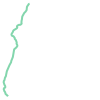

In [43]:
DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == 'V40') & (DF_ROUTES_EXTRA_LINES['route_long_name'] != 'Melbourne - Seymour Via Broadmeadows')].iloc[0]['geometry']

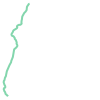

In [45]:
DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == 'V40') & (DF_ROUTES_EXTRA_LINES['route_long_name'] == 'Melbourne - Seymour Via Broadmeadows')].iloc[0]['geometry']

In [66]:
DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == '900')]['route_long_name']

142               Stud Park SC - Caulfield
143               Stud Park SC - Caulfield
144               Stud Park SC - Caulfield
145               Stud Park SC - Caulfield
146               Stud Park SC - Caulfield
147               Stud Park SC - Caulfield
148    Caulfield - Stud Park SC (Rowville)
149    Caulfield - Stud Park SC (Rowville)
150    Caulfield - Stud Park SC (Rowville)
Name: route_long_name, dtype: object

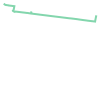

In [49]:
DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == '900')].iloc[0]['geometry']

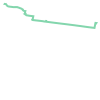

In [55]:
DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == '900')]['geometry'][149]

In [73]:
k = DF_ROUTES_EXTRA_LINES[(DF_ROUTES_EXTRA_LINES['route_name'] == '900')]['geometry']

result_matrix = [[0 for i in range(142, 151)] for j in range(142, 151)]
for ix in range(142, 151):
    for ix2 in range(142, 151):
        result_matrix[ix-142][ix2-142] = 1 if k[ix] == k[ix2] else ' '

In [77]:
DF_LINES[DF_LINES['line']]

0     [(144.320994804276, -36.7063405768129), (144.3...
1     [(144.753202472533, -36.1310044648301), (144.7...
2     [(144.283008928887, -36.7656697308466), (144.2...
3     [(144.283008928887, -36.7656697308466), (144.2...
4     [(144.952513264004, -37.8183431013081), (144.9...
                            ...                        
15    [(144.952513264004, -37.8183431013081), (144.9...
0     [(144.849200325743, -37.672314213378), (144.85...
1     [(145.121512277514, -38.1423300209907), (145.1...
2     [(144.849200325743, -37.672314213378), (144.84...
3     [(144.95267304005, -37.8158496277039), (144.95...
Name: line, Length: 11017, dtype: object

In [98]:
DF_ROUTES_EXTRA[DF_ROUTES_EXTRA['route_short_name'].isna()].groupby(['opbranch', 'route_name'])['route_long_name'].aggregate(np.array)

opbranch  route_name
1         V40           [Melbourne - Seymour Via Broadmeadows, Melbour...
5         Sht           [Shepparton Via Seymour, Shepparton - Melbourn...
          V05           [Melbourne Via Melton, Ballarat - Melbourne Vi...
          V08           [Melbourne - Bairnsdale Via Sale & Traralgon, ...
          V13           [Canberra Via Bairnsdale, Melbourne Via Bairns...
          V23           [Geelong - Melbourne Via Geelong, Geelong - Me...
          V40           [Melbourne - Seymour Via Broadmeadows, Melbour...
          V45           [Melbourne - Swan Hill Via Bendigo, Melbourne ...
          V48           [Traralgon - Melbourne Via Pakenham, Moe & Mor...
Name: route_long_name, dtype: object

In [112]:
DF_ROUTE_NAMES = DFROUTES.groupby('route_name').aggregate({'route_short_name': 'unique', 'route_long_name': 'unique', 'opbranch': 'unique', 'branch': 'unique'}).reset_index()

In [115]:
DF_ROUTE_NAMES[DF_ROUTE_NAMES['route_name'] == 'V13']['route_long_name'].iloc[0]

array(['Canberra Via Bairnsdale', 'Melbourne Via Bairnsdale',
       'Canberra - Melbourne Via Bairnsdale'], dtype=object)

In [117]:
DF_ROUTES_EXTRA[['route_name', 'opbranch', 'route_long_name']].drop_duplicates()

,route_name,opbranch,route_long_name
0,V40,1,Melbourne - Seymour Via Broadmeadows
5,V40,1,Seymour
18,GSR,10,Melbourne
20,GSR,10,Adelaide
23,GSR,10,Melbourne - Adelaide
30,ain,2,Flinders Street
31,ain,2,Showgrounds/Flemington - Flinders Street
34,675,4,Chirnside Park SC - Mooroolbark
35,675,4,Mooroolbark - Chirnside Park SC
37,843,4,Mossgiel Park - Dandenong
